In [142]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torchvision import datasets, transforms
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

import matplotlib.pyplot as plt

In [143]:
import os
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive')
#print(os.listdir(GOOGLE_DRIVE_PATH))
import sys
from google.colab import drive
sys.path.append(GOOGLE_DRIVE_PATH)
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [144]:
# hard-code random seeds for deterministic outcomes
np.random.seed(42)
torch.manual_seed(42)

In [145]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200,10)

    def forward(self, x):
        x = x.view((-1, 28*28))
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        return x

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(5, 5))
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(5, 5))
        self.bn2 = nn.BatchNorm2d(32)
        self.conv2_drop = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(128, 100)
        self.fc2 = nn.Linear(100, 10)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3))
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=(3, 3))
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=(1, 1))
        self.bn6 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.conv2_drop(F.max_pool2d(self.bn2(x), 2))
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2_drop(x)
        x = F.relu(self.conv5(x))
        x = self.bn5(x)
        x = F.relu(self.conv6(x))
        x = self.bn6(x)
        size = x.size()[1] * x.size()[2] * x.size()[3]
        # print(size)
        x = x.view(-1, size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [146]:
# loading the dataset
# note that this time we do not perfrom the normalization operation, see next cell
test_dataset = datasets.MNIST(
    'mnist_data/',
    train=False,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor()]
    )
)

In [147]:
class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# we load the body of the pre-trained neural net...
model = torch.load('/content/drive/MyDrive/model.net', map_location='cpu')

# ... and add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), model)

# and here we also create a version of the model that outputs the class probabilities
model_to_prob = nn.Sequential(model, nn.Softmax())

# we put the neural net into evaluation mode (this disables features like dropout)
model.eval()
model_to_prob.eval()

<ipython-input-147-5b04f904e8a3>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/model.net', map_location='cpu')
/usr/local/lib/p

Sequential(
  (0): Sequential(
    (0): Normalize()
    (1): ConvNet(
      (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2_drop): Dropout2d(p=0.2, inplace=False)
      (fc1): Linear(in_features=128, out_features=100, bias=True)
      (fc2): Linear(in_features=100, out_features=10, bias=True)
      (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (bn5): BatchNorm2d(128, eps=1e-05, momentum=

In [148]:
def show(original, adv, model_to_prob):
    p0 = model_to_prob(original).detach().numpy()
    p1 = model_to_prob(adv).detach().numpy()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(original.detach().numpy().reshape(28, 28), cmap='gray')
    axarr[0].set_title("Original, class: " + str(p0.argmax()))
    axarr[1].imshow(adv.detach().numpy().reshape(28, 28), cmap='gray')
    axarr[1].set_title("Adversarial, class: " + str(p1.argmax()))
    print("Class\t\tOrig\tAdv")
    for i in range(10):
        print("Class {}:\t{:.2f}\t{:.2f}".format(i, float(p0[:, i]), float(p1[:, i])))
    plt.show()

In [149]:
def fgsm_(model, x, target, eps, targeted=True, clip_min=None, clip_max=None):
    """Internal process for all FGSM and PGD attacks."""
    # create a copy of the input, remove all previous associations to the compute graph...
    input_ = x.clone().detach_()
    # ... and make sure we are differentiating toward that variable
    input_.requires_grad_()

    # run the model and obtain the loss
    logits = model(input_)
    target = torch.LongTensor([target])
    model.zero_grad()
    loss = nn.CrossEntropyLoss()(logits, target)
    loss.backward()

    #perfrom either targeted or untargeted attack
    if targeted:
        out = input_ - eps * input_.grad.sign()
    else:
        out = input_ + eps * input_.grad.sign()

    #if desired clip the ouput back to the image domain
    if (clip_min is not None) or (clip_max is not None):
        out.clamp_(min=clip_min, max=clip_max)
    return out

In [160]:
# x: input image
# label: current label of x
# k: number of FGSM iterations
# eps: size of l-infinity ball
# eps_step: step size of FGSM iterations

def pgd(model, x, label, k, eps, eps_step, targeted, clip_min, clip_max):
    x_adv = x.clone().detach() + torch.FloatTensor(x.shape).uniform_(-eps, eps)
    x_adv.clamp_(min=clip_min, max=clip_max)
    x_min = x - eps
    x_max = x + eps
    for i in range(k):
      x_adv = fgsm_(model, x_adv, label, eps_step, targeted)
      x_adv = torch.min(x_max, torch.max(x_min, x_adv))
      x_adv.clamp_(min=clip_min, max=clip_max)
    return x_adv


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
<ipython-input-148-9a195dd56465>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Class {}:\t{:.2f}\t{:.2f}".format(i, float(p0[:, i]), float(p1[:, i])))


Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	0.00	0.00
Class 2:	0.00	1.00
Class 3:	0.00	0.00
Class 4:	0.00	0.00
Class 5:	0.00	0.00
Class 6:	0.00	0.00
Class 7:	1.00	0.00
Class 8:	0.00	0.00
Class 9:	0.00	0.00


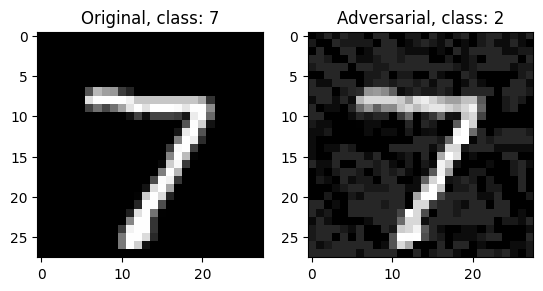

In [161]:
# try out our attacks
original = torch.unsqueeze(test_dataset[0][0], dim=0)

adv = pgd(model, original, label=7, k=10, eps=0.15, eps_step=0.05, targeted=False, clip_min=0, clip_max=1.0)

show(original, adv, model_to_prob)